In [1]:
import os
from os.path import join, exists, isfile, realpath, dirname
import argparse
from glob import glob
import random, shutil, json
from math import log10, ceil

import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from torch.utils.data.dataset import Subset

import faiss

import netvlad

import torch.optim as optim
from tensorboardX import SummaryWriter

from datetime import datetime
from os import makedirs, remove, chdir, environ

import matplotlib.pyplot as plt

import cv2

import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R

import pyquaternion as pyq
import math
from tqdm import tqdm

import sys
sys.path.append("/home/ubuntu/Desktop/SuperPoint-VO/")

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
weight_dir = 'Jun10_11-22-16_vgg16_netvlad'
lidar_map_pcd = None

In [3]:
parser = argparse.ArgumentParser(description='pytorch-NetVlad')
parser.add_argument('--mode', type=str, default='train', help='Mode', choices=['train', 'test', 'cluster'])
parser.add_argument('--batchSize', type=int, default=4, help='Number of triplets (query, pos, negs). Each triplet consists of 12 images.')
parser.add_argument('--cacheBatchSize', type=int, default=24, help='Batch size for caching and testing')
parser.add_argument('--cacheRefreshRate', type=int, default=1000, help='How often to refresh cache, in number of queries. 0 for off')
parser.add_argument('--nEpochs', type=int, default=30, help='number of epochs to train for')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('--nGPU', type=int, default=1, help='number of GPU to use.')
parser.add_argument('--optim', type=str, default='SGD', help='optimizer to use', choices=['SGD', 'ADAM'])
parser.add_argument('--lr', type=float, default=0.0001, help='Learning Rate.')
parser.add_argument('--lrStep', type=float, default=5, help='Decay LR ever N steps.')
parser.add_argument('--lrGamma', type=float, default=0.5, help='Multiply LR by Gamma for decaying.')
parser.add_argument('--weightDecay', type=float, default=0.001, help='Weight decay for SGD.')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGD.')
parser.add_argument('--nocuda', action='store_true', help='Dont use cuda')
parser.add_argument('--threads', type=int, default=8, help='Number of threads for each data loader to use')
parser.add_argument('--seed', type=int, default=123, help='Random seed to use.')
parser.add_argument('--dataPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/data/', help='Path for centroid data.')
parser.add_argument('--runsPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', help='Path to save runs to.')
parser.add_argument('--savePath', type=str, default='checkpoints', help='Path to save checkpoints to in logdir. Default=checkpoints/')
parser.add_argument('--cachePath', type=str, default='/tmp', help='Path to save cache to.')
parser.add_argument('--resume', type=str, default='', help='Path to load checkpoint from, for resuming training or testing.')
parser.add_argument('--ckpt', type=str, default='latest', help='Resume from latest or best checkpoint.', choices=['latest', 'best'])
parser.add_argument('--evalEvery', type=int, default=1, help='Do a validation set run, and save, every N epochs.')
parser.add_argument('--patience', type=int, default=10, help='Patience for early stopping. 0 is off.')
parser.add_argument('--dataset', type=str, default='pittsburgh', help='Dataset to use', choices=['pittsburgh','naverlabs'])
parser.add_argument('--arch', type=str, default='vgg16', help='basenetwork to use', choices=['vgg16', 'alexnet'])
parser.add_argument('--vladv2', action='store_true', help='Use VLAD v2')
parser.add_argument('--pooling', type=str, default='netvlad', help='type of pooling to use', choices=['netvlad', 'max', 'avg'])
parser.add_argument('--num_clusters', type=int, default=64, help='Number of NetVlad clusters. Default=64')
parser.add_argument('--margin', type=float, default=0.1, help='Margin for triplet loss. Default=0.1')
parser.add_argument('--split', type=str, default='val', help='Data split to use for testing. Default is val', choices=['test', 'test250k', 'train', 'val'])
parser.add_argument('--fromscratch', action='store_true', help='Train from scratch rather than using pretrained models')

_StoreTrueAction(option_strings=['--fromscratch'], dest='fromscratch', nargs=0, const=True, default=False, type=None, choices=None, help='Train from scratch rather than using pretrained models', metavar=None)

In [4]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

from os.path import join, exists
from scipy.io import loadmat
import numpy as np
from collections import namedtuple
from PIL import Image

from sklearn.neighbors import NearestNeighbors
import h5py

def input_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])

def get_whole_test_set():
    return WholeDatasetFromStruct(input_transform=input_transform(), mode='test')

dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
                                   'db_image', 'db_utms', 'db_num', 'db_full_pose',
                                   'q_image', 'q_utms', 'q_num', 'q_full_pose',
                                   'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

class WholeDatasetFromStruct(data.Dataset):
    def __init__(self, input_transform=None, mode='train'):
        super().__init__()

        self.input_transform = input_transform

        self.dbStruct = my_parse_dbStruct(mode)
        self.images = np.hstack([self.dbStruct.db_image, self.dbStruct.q_image])

        self.whichSet = self.dbStruct.whichSet
        self.dataset = self.dbStruct.dataset

        self.positives = None
        self.distances = None

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = img.resize((640, 480))

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

    def getPositives(self):
        # positives for evaluation are those within trivial threshold range
        #fit NN to find them, search by radius
        if  self.positives is None:
            knn = NearestNeighbors(n_jobs=-1)
            knn.fit(self.dbStruct.db_utms)

            self.distances, self.positives = knn.radius_neighbors(self.dbStruct.q_utms, radius=self.dbStruct.posDistThr)

        return self.positives


In [5]:
def my_parse_dbStruct(_whichSet='train'):

    whichSet = _whichSet
    dataset = 'naverlabs'
    
    # for (2019-04-16_15-35-46)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/images'
    image_files_list = []
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970285*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970286*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970288*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970289*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970290*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970291*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/groundtruth.hdf5'
    full_pose_list = []
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['22970285_pose']))
        full_pose_list.append(np.array(f['22970286_pose']))
        full_pose_list.append(np.array(f['22970288_pose']))
        full_pose_list.append(np.array(f['22970289_pose']))
        full_pose_list.append(np.array(f['22970290_pose']))
        full_pose_list.append(np.array(f['22970291_pose']))
    
    # for (2019-04-16_16-14-48)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/images'
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970285*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970286*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970288*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970289*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970290*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970291*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/groundtruth.hdf5'
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['22970285_pose']))
        full_pose_list.append(np.array(f['22970286_pose']))
        full_pose_list.append(np.array(f['22970288_pose']))
        full_pose_list.append(np.array(f['22970289_pose']))
        full_pose_list.append(np.array(f['22970290_pose']))
        full_pose_list.append(np.array(f['22970291_pose']))
        full_pose_list.append(np.array(f['AC01324954_pose']))
        full_pose_list.append(np.array(f['AC01324955_pose']))
        full_pose_list.append(np.array(f['AC01324969_pose']))
    
    # for (2019-08-20_10-41-18)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/images'
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324968*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/groundtruth.hdf5'
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['AC01324954_pose']))
        full_pose_list.append(np.array(f['AC01324955_pose']))
        full_pose_list.append(np.array(f['AC01324968_pose']))
        full_pose_list.append(np.array(f['AC01324969_pose']))
       
    db_image = np.hstack(image_files_list)
    db_full_pose = np.vstack(full_pose_list)
    db_num = len(db_image)
    db_utms = db_full_pose[:,:2]
    
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/test/2019-08-21_09-49-05/images'
    image_files_list = []
    image_files_list.append(sorted(glob(os.path.join(image_path, '40027089*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40029628*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40030065*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40031951*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40033113*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40033116*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324968*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    image_files = np.hstack(image_files_list)
    
    q_image = image_files
    q_utms = None
    q_num = len(q_image)
    q_full_pose = None    

    return dbStruct(whichSet, dataset, 
                    db_image, db_utms, db_num, db_full_pose,
                    q_image, q_utms, q_num, q_full_pose, 
                    5, 25, 20.0)

In [6]:
opt = parser.parse_args(args=('--dataset=naverlabs --mode=test --resume=runs/%s --split=test' % weight_dir).split(' '))
restore_var = ['lr', 'lrStep', 'lrGamma', 'weightDecay', 'momentum', 
            'runsPath', 'savePath', 'arch', 'num_clusters', 'pooling', 'optim',
            'margin', 'seed', 'patience']

flag_file = join(opt.resume, 'checkpoints', 'flags.json')
if exists(flag_file):
    with open(flag_file, 'r') as f:
        stored_flags = {'--'+k : str(v) for k,v in json.load(f).items() if k in restore_var}
        to_del = []
        for flag, val in stored_flags.items():
            for act in parser._actions:
                if act.dest == flag[2:]:
                    # store_true / store_false args don't accept arguments, filter these 
                    if type(act.const) == type(True):
                        if val == str(act.default):
                            to_del.append(flag)
                        else:
                            stored_flags[flag] = ''
        for flag in to_del: del stored_flags[flag]

        train_flags = [x for x in list(sum(stored_flags.items(), tuple())) if len(x) > 0]
        print('Restored flags:', train_flags)
        opt = parser.parse_args(train_flags, namespace=opt)




Restored flags: ['--optim', 'SGD', '--lr', '0.0001', '--lrStep', '5', '--lrGamma', '0.5', '--weightDecay', '0.001', '--momentum', '0.9', '--seed', '123', '--runsPath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/', '--savePath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun10_11-22-16_vgg16_netvlad/checkpoints', '--patience', '10', '--arch', 'vgg16', '--pooling', 'netvlad', '--num_clusters', '64', '--margin', '0.1']


In [7]:
print(opt)

Namespace(arch='vgg16', batchSize=4, cacheBatchSize=24, cachePath='/tmp', cacheRefreshRate=1000, ckpt='latest', dataPath='/home/ubuntu/Desktop/pytorch-NetVlad/data/', dataset='naverlabs', evalEvery=1, fromscratch=False, lr=0.0001, lrGamma=0.5, lrStep=5.0, margin=0.1, mode='test', momentum=0.9, nEpochs=30, nGPU=1, nocuda=False, num_clusters=64, optim='SGD', patience=10, pooling='netvlad', resume='runs/Jun10_11-22-16_vgg16_netvlad', runsPath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', savePath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun10_11-22-16_vgg16_netvlad/checkpoints', seed=123, split='test', start_epoch=0, threads=8, vladv2=False, weightDecay=0.001)


In [8]:
cuda = True
device = torch.device("cuda")
random.seed(opt.seed)
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)

In [9]:
whole_test_set = get_whole_test_set()

In [10]:
encoder_dim = 512
encoder = models.vgg16(pretrained=True)
# capture only feature part and remove last relu and maxpool
layers = list(encoder.features.children())[:-2]

# if using pretrained then only train conv5_1, conv5_2, and conv5_3
for l in layers[:-5]: 
    for p in l.parameters():
        p.requires_grad = False

In [11]:
encoder = nn.Sequential(*layers)
model = nn.Module() 
model.add_module('encoder', encoder)

In [12]:
net_vlad = netvlad.NetVLAD(num_clusters=opt.num_clusters, dim=encoder_dim, vladv2=opt.vladv2)
if not opt.resume: 
    if opt.mode.lower() == 'train':
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + train_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')
    else:
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + whole_test_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')

    if not exists(initcache):
        raise FileNotFoundError('Could not find clusters, please run with --mode=cluster before proceeding')

    with h5py.File(initcache, mode='r') as h5: 
        clsts = h5.get("centroids")[...]
        traindescs = h5.get("descriptors")[...]
        net_vlad.init_params(clsts, traindescs) 
        del clsts, traindescs

model.add_module('pool', net_vlad)

In [13]:
if opt.ckpt.lower() == 'latest':
    resume_ckpt = join(opt.resume, 'checkpoints', 'checkpoint.pth.tar')
elif opt.ckpt.lower() == 'best':
    resume_ckpt = join(opt.resume, 'checkpoints', 'model_best.pth.tar')

if isfile(resume_ckpt):
    print("=> loading checkpoint '{}'".format(resume_ckpt))
    checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
    opt.start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_score']
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    if opt.mode == 'train':
        optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume_ckpt, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_ckpt))

=> loading checkpoint 'runs/Jun10_11-22-16_vgg16_netvlad/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'runs/Jun10_11-22-16_vgg16_netvlad/checkpoints/checkpoint.pth.tar' (epoch 22)


# Calculate the prediction

In [14]:
test_set = whole_test_set
test_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.cacheBatchSize, shuffle=True, pin_memory=cuda)

In [15]:
model.eval()
with torch.no_grad():
    print('====> Extracting Features')
    pool_size = encoder_dim
    if opt.pooling.lower() == 'netvlad': pool_size *= opt.num_clusters
    dbFeat = np.empty((len(test_set), pool_size))

    for iteration, (input, indices) in enumerate(test_data_loader, 1):
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 

        dbFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(test_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, len(test_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding
del test_data_loader

====> Extracting Features
==> Batch (50/1198)
==> Batch (100/1198)
==> Batch (150/1198)
==> Batch (200/1198)
==> Batch (250/1198)
==> Batch (300/1198)
==> Batch (350/1198)
==> Batch (400/1198)
==> Batch (450/1198)
==> Batch (500/1198)
==> Batch (550/1198)
==> Batch (600/1198)
==> Batch (650/1198)
==> Batch (700/1198)
==> Batch (750/1198)
==> Batch (800/1198)
==> Batch (850/1198)
==> Batch (900/1198)
==> Batch (950/1198)
==> Batch (1000/1198)
==> Batch (1050/1198)
==> Batch (1100/1198)
==> Batch (1150/1198)


In [16]:
# extracted for both db and query, now split in own sets
qFeat = dbFeat[test_set.dbStruct.db_num:].astype('float32')
dbFeat = dbFeat[:test_set.dbStruct.db_num].astype('float32')

print('====> Building faiss index')
faiss_index = faiss.IndexFlatL2(pool_size)
faiss_index.add(dbFeat)

print('====> Calculating recall @ N')
n_values = [1,5,10,20]

_, predictions = faiss_index.search(qFeat, max(n_values)) 

====> Building faiss index
====> Calculating recall @ N


# Place Recognition

In [17]:
from utility import *

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [19]:
def placeRecognitionBestOnly(dataset, query_idx, viz=True):
    
    query_image_full_path = dataset.dbStruct.q_image[query_idx]
    query_img = Image.open(query_image_full_path)
    query_pose = None

    pred_image_full_path = dataset.dbStruct.db_image[predictions[query_idx][0]]
    pred_img = Image.open(pred_image_full_path) 
    pred_pose = dataset.dbStruct.db_full_pose[predictions[query_idx][0]]
    
    if (viz):
        fig = plt.figure()
        ax1 = fig.add_subplot(2,1,1)
        ax1.title.set_text('query image')
        ax1.imshow(query_img)
        ax2 = fig.add_subplot(2,1,2)
        ax2.title.set_text('best reference image')
        ax2.imshow(pred_img)
        plt.show()
    
    return query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose

In [20]:
def projection(img, _points, _A, _Rt, thickness=1):

    projected_img = np.ones_like(img)*np.inf
    agumented_points = np.c_[_points,np.ones(_points.shape[0])]
    transformed_points = np.linalg.inv(_Rt)@np.transpose(agumented_points)
    projected_points = _A@transformed_points[:3,:]
    hnormalized_points = projected_points/projected_points[2,:]
    
    for i, hnormalized_point in enumerate(np.transpose(hnormalized_points)):
        
        new_val = transformed_points[:3,i]
        if (0 < new_val[2]): # points in front of the camera

            t_y = int(hnormalized_point[1])
            t_x = int(hnormalized_point[0])
            if (0 <= t_x and t_x < img.size[0] and 0 <= t_y and t_y < img.size[1]): # points inside of the image

                pre_val = projected_img[t_y, t_x]
                if (new_val[2] < pre_val[2]):
                    projected_img[t_y-thickness:t_y+thickness, t_x-thickness:t_x+thickness] = new_val

    return projected_img


# NetVLAD Query

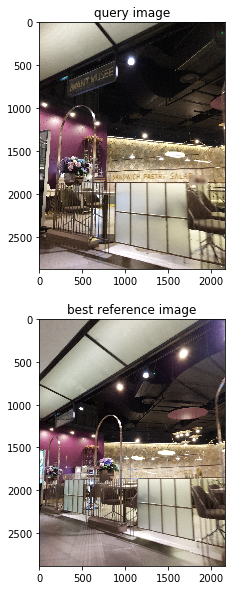

query :  /home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/test/2019-08-21_09-49-05/images/AC01324955_1566000000000084.jpg
pred :  /home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/images/AC01324969_1566265478652000.jpg


In [35]:
query_idx = np.random.randint(test_set.dbStruct.q_num)
query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose = placeRecognitionBestOnly(dataset=test_set, query_idx=query_idx)
print('query : ', query_image_full_path)
print('pred : ', pred_image_full_path)

In [23]:
# VERY TIME CONSUMING!
lidar_map_pcd1 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/map.pcd")
pcd_tree1 = o3d.geometry.KDTreeFlann(lidar_map_pcd1)

lidar_map_pcd2 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/map.pcd")
pcd_tree2 = o3d.geometry.KDTreeFlann(lidar_map_pcd2)

lidar_map_pcd3 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/map.pcd")
pcd_tree3 = o3d.geometry.KDTreeFlann(lidar_map_pcd3)

In [37]:
neighbor_radius = 15.0

acquisition_date = pred_image_full_path.split('/')[-3] 
if acquisition_date == '2019-08-20_10-41-18':
    [k, idx, _] = pcd_tree1.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
    pcd = lidar_map_pcd1
elif acquisition_date == '2019-04-16_16-14-48':
    [k, idx, _] = pcd_tree2.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
    pcd = lidar_map_pcd2
elif acquisition_date == '2019-04-16_15-35-46':
    [k, idx, _] = pcd_tree3.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
    pcd = lidar_map_pcd3

print('the number of neighbors: ', k)

the number of neighbors:  9164657


In [38]:
radius_points = np.asarray(pcd.points)[idx] 

pred_Rt = np.eye(4)
pred_Rt[:3,3] = pred_pose[:3]
(pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()

pred_camera_model = pred_image_full_path.split('/')[-1].split('_')[0]
_, pred_A, pred_dist_coeff = intrinsic_params(pred_camera_model)
pred_projected_img = projection(pred_img, radius_points, pred_A, pred_Rt, thickness=3)

query_camera_model = query_image_full_path.split('/')[-1].split('_')[0]
_, query_A, query_dist_coeff = intrinsic_params(query_camera_model)

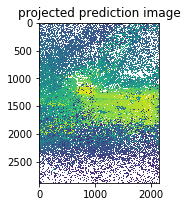

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(pred_projected_img[:,:,2])
ax1.title.set_text('projected prediction image')
plt.show()

# Superpoint feature extraction and matching

In [25]:
from sp_extractor import SuperPointFrontend, PointTracker

In [26]:
class SP_VisualOdometry:
    def __init__(self):
        self.frame_stage = 0
        self.cam = None
        self.new_frame = None
        self.last_frame = None
        self.cur_R = None
        self.cur_t = None
        self.px_ref = None
        self.px_cur = None
        self.focal = None
        self.pp = None
        self.trueX, self.trueY, self.trueZ = 0, 0, 0
        self.detector = SuperPointFrontend(weights_path="/home/ubuntu/Desktop/SuperPoint-VO/weights/superpoint_v1.pth",
                                           nms_dist=4,
                                           conf_thresh=0.015,
                                           nn_thresh=0.7,
                                           cuda=True)
        self.tracker = PointTracker(max_length=2, nn_thresh=self.detector.nn_thresh)

    def featureTracking(self, new_frame):
        pts, desc, heatmap = self.detector.run(new_frame)
        # Add points and descriptors to the tracker.
        self.tracker.update(pts, desc)
        # Get tracks for points which were match successfully across all frames.
        tracks = self.tracker.get_tracks(min_length=1)
        # Normalize track scores to [0,1].
        tracks[:, 1] /= float(self.detector.nn_thresh)
        kp1, kp2 = self.tracker.draw_tracks(tracks)
        return kp1, kp2

In [27]:
sp_vo = SP_VisualOdometry()

query_img_sp = cv2.imread(query_image_full_path)
pred_img_sp = cv2.imread(pred_image_full_path)

query_img_sp = cv2.undistort(query_img_sp, query_A, query_dist_coeff)
pred_img_sp = cv2.undistort(pred_img_sp, pred_A, pred_dist_coeff)

sp_vo.featureTracking(query_img_sp)
px_query, px_pred = sp_vo.featureTracking(pred_img_sp)
curr_size = px_pred.shape[0]

NameError: name 'query_image_full_path' is not defined

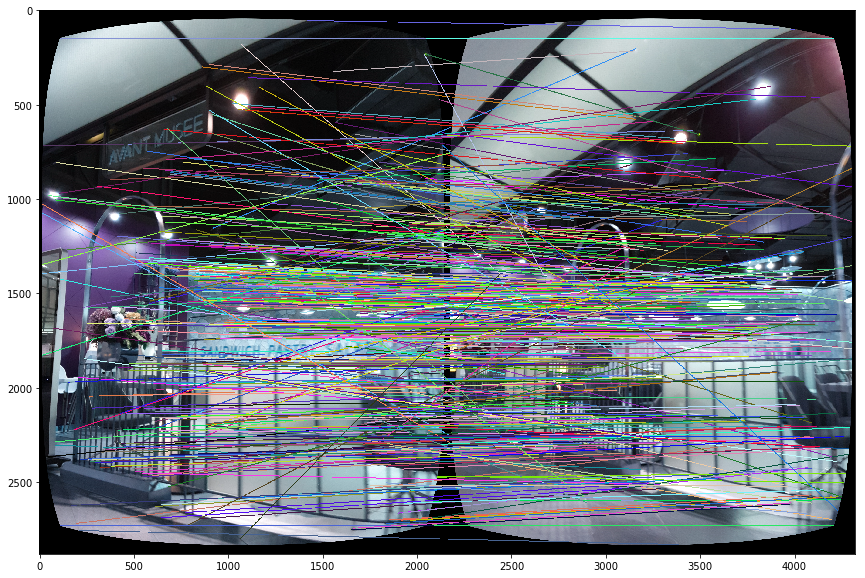

In [45]:
corr_img_h = max(query_img_sp.shape[0], pred_img_sp.shape[0])
corr_img_w = query_img_sp.shape[1] + pred_img_sp.shape[1]

corr_img = np.zeros((corr_img_h, corr_img_w, 3))
corr_img[0:,0:query_img_sp.shape[1],:] = query_img_sp/255.0
corr_img[0:pred_img_sp.shape[0],query_img_sp.shape[1]:,:] = pred_img_sp/255.0

for corr_idx in range(curr_size):
    if (corr_idx % 1 == 0):
        corr_img = cv2.line(corr_img, 
                            (px_query[corr_idx][0],px_query[corr_idx][1]), 
                            (pred_img_sp.shape[1]+px_pred[corr_idx][0], px_pred[corr_idx][1]), 
                            (np.random.rand(),np.random.rand(),np.random.rand()), 3)
plt.figure()
plt.imshow(corr_img)

# Perspective-N-Points

True


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


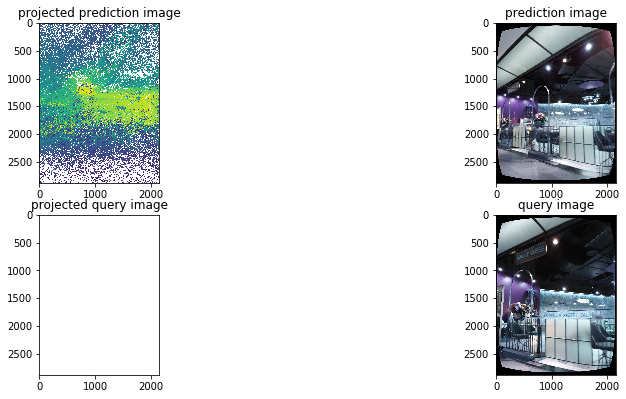

In [44]:
points_2d = []
points_3d = []
for corr_idx in range(curr_size):
    if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
        points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
        points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])
        
points_2d = np.asarray(points_2d, dtype=np.float32)
points_3d = np.asarray(points_3d, dtype=np.float32)

retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, query_A, query_dist_coeff)
print(retval)

if (retval):  
    rotation_matrix = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvec, rotation_matrix)
    query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
    query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]
    query_Rt = np.eye(4)
    query_Rt[:3,:3] = query_rot
    query_Rt[:3,3] = query_trans
    query_projected_img = projection(query_img, radius_points, query_A, query_Rt, thickness=3)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.imshow(pred_projected_img[:,:,2])
    ax1.title.set_text('projected prediction image')
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.imshow(pred_img_sp)
    ax2.title.set_text('prediction image')

    ax3 = fig.add_subplot(3, 2, 3)
    ax3.imshow(query_projected_img[:,:,2])
    ax3.title.set_text('projected query image')
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.imshow(query_img_sp)
    ax4.title.set_text('query image')
    plt.show()

# All-in-one

In [21]:
def VisualLocalization(query_idx, viz=False):
    
    # parameters
    neighbor_radius = 15.0
    
    query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose = placeRecognitionBestOnly(dataset=test_set, query_idx=query_idx, viz=viz)
    if (viz):
        print('query : ', query_image_full_path)
        print('pred : ', pred_image_full_path)

    acquisition_date = pred_image_full_path.split('/')[-3] 
    if acquisition_date == '2019-08-20_10-41-18':
        [k, idx, _] = pcd_tree1.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
        pcd = lidar_map_pcd1
    elif acquisition_date == '2019-04-16_16-14-48':
        [k, idx, _] = pcd_tree2.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
        pcd = lidar_map_pcd2
    elif acquisition_date == '2019-04-16_15-35-46':
        [k, idx, _] = pcd_tree3.search_radius_vector_3d(pred_pose[:3], neighbor_radius)
        pcd = lidar_map_pcd3
    
    radius_points = np.asarray(pcd.points)[idx] 

    pred_Rt = np.eye(4)
    pred_Rt[:3,3] = pred_pose[:3]
    (pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
    pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()

    pred_camera_model = pred_image_full_path.split('/')[-1].split('_')[0]
    _, pred_A, pred_dist_coeff = intrinsic_params(pred_camera_model)
    pred_projected_img = projection(pred_img, radius_points, pred_A, pred_Rt, thickness=3)

    query_camera_model = query_image_full_path.split('/')[-1].split('_')[0]
    _, query_A, query_dist_coeff = intrinsic_params(query_camera_model)
    
    sp_vo = SP_VisualOdometry()

    query_img_sp = cv2.imread(query_image_full_path)
    pred_img_sp = cv2.imread(pred_image_full_path)

    query_img_sp = cv2.undistort(query_img_sp, query_A, query_dist_coeff)
    pred_img_sp = cv2.undistort(pred_img_sp, pred_A, pred_dist_coeff)

    sp_vo.featureTracking(query_img_sp)
    px_query, px_pred = sp_vo.featureTracking(pred_img_sp)
    curr_size = px_pred.shape[0]
    
    points_2d = []
    points_3d = []
    for corr_idx in range(curr_size):
        if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
            points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
            points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])

    points_2d = np.asarray(points_2d, dtype=np.float32)
    points_3d = np.asarray(points_3d, dtype=np.float32)

    retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, query_A, query_dist_coeff)

    if retval==False:
        return False, None, None, None
        
    rotation_matrix = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvec, rotation_matrix)
    
    query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
    query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]

    query_Rt = np.eye(4)
    query_Rt[:3,:3] = query_rot
    query_Rt[:3,3] = query_trans
    
    result_images = None
    if (viz):
        query_projected_img = projection(query_img, radius_points, query_A, query_Rt, thickness=3) 
        result_images = (pred_img, pred_projected_img, query_img, query_projected_img)

    query_quat = R.from_matrix(query_rot).as_quat()
    result_pose = (query_quat,query_trans)
    
    return True, query_image_full_path, result_images, result_pose

# Test One

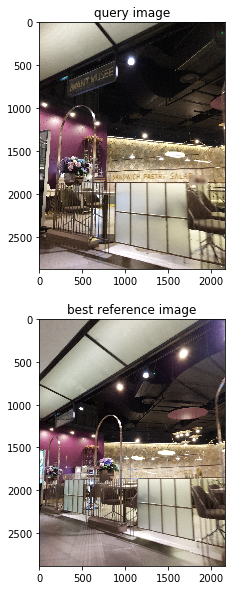

query :  /home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/test/2019-08-21_09-49-05/images/AC01324955_1566000000000084.jpg
pred :  /home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/images/AC01324969_1566265478652000.jpg


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/si

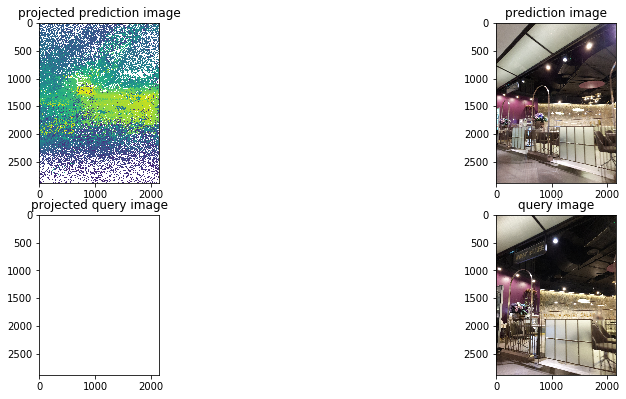

In [28]:
query_idx = np.random.randint(test_set.dbStruct.q_num)
ret_val, query_image_full_path , result_images, result_pose = VisualLocalization(query_idx=query_idx, viz=True)

if (ret_val):
    (pred_img, pred_projected_img, query_img, query_projected_img) = result_images

    fig = plt.figure()

    ax1 = fig.add_subplot(3, 2, 1)
    ax1.imshow(pred_projected_img[:,:,2])
    ax1.title.set_text('projected prediction image')
    ax2 = fig.add_subplot(3, 2, 2)
    ax2.imshow(pred_img)
    ax2.title.set_text('prediction image')

    ax3 = fig.add_subplot(3, 2, 3)
    ax3.imshow(query_projected_img[:,:,2])
    ax3.title.set_text('projected query image')
    ax4 = fig.add_subplot(3, 2, 4)
    ax4.imshow(query_img)
    ax4.title.set_text('query image')

    plt.show()

# Test ALL

In [ ]:
result_list = []
for query_idx in tqdm(range(test_set.dbStruct.q_num)):
    
    try:
        ret_val, query_image_full_path , result_images, result_pose = VisualLocalization(query_idx, viz=False)
    except KeyboardInterrupt: 
        break
    except: 
        continue
        
    if ret_val == True:        
        temp_dict = {
                 'floor': "b1",
                 'name': query_image_full_path.split('/')[-1],
                 'qw': result_pose[0][3],
                 'qx': result_pose[0][0],
                 'qy': result_pose[0][1],
                 'qz': result_pose[0][2],
                 'x': result_pose[1][0][0],
                 'y': result_pose[1][0][1],
                 'z': result_pose[1][0][2]
        }

        result_list.append(temp_dict)

    if (query_idx % 10 == 0):
        with open('20200612_indoor_submit.json', 'w') as outfile:
            json.dump(result_list, outfile)

  0%|          | 0/1961 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
 81%|████████▏ | 1597/1961 [11:16:40<2:38:40, 26.15s/it]

In [31]:
with open('20200612_indoor_submit.json', 'w') as outfile:
    json.dump(result_list, outfile)

In [32]:
print('hellow')

hellow
